** Notes **

[Sklearn's K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) supports sparse matrices

However the Gaussian Mixture model does not, and as such I subsample the IMDB dataset so that it fits into memory

### Initial Setup

In [1]:
import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
import time
import sklearn
import pylab
import matplotlib.pyplot as plt
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import os.path
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from skimage.color import rgb2gray
from sklearn.exceptions import DataConversionWarning
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.random_projection import SparseRandomProjection as SRP
from sklearn.feature_selection import VarianceThreshold as VTSelector
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
import torch.nn
import warnings
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
import keras.layers as layers
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils 
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning
try:
    from google.colab import files
except ImportError:
  print("[0x000] | " + "Not running on colab")
  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

# Hopefully memory is less of an issue with colab, but I'll keep this in case
NP_DATA_TYPE = np.float32

CIFAR = "CIFAR"
DATASET = CIFAR

PCA_CODE = "PCA"
ICA_CODE = "ICA"
RANDPROJ_CODE = "Randomized Projections"

KEY_PREPROC = "preproc"
KEY_DIMRED = "dimred"
KEY_CLUST = "clust"
KEY_PIPELINE = "pipeline"
KEY_TRAINING = "training"
KEY_REPS = "reps"

Using TensorFlow backend.


### Common methods used throughout

In [0]:
def augmented_split(*args, test_size=None, shuffle=True, random_state=None):
  
    if test_size < 0 or test_size >= 1:
        raise RuntimeError("Cant handle test fraction of ", str(test_size))
    
    if test_size == 0:
        out = [(a, None) for a in args]
        return itertools.chain(*out)
    else:
      return train_test_split(*args, 
                              test_size=test_size, 
                              shuffle=shuffle,
                              random_state=random_state)
    
def split_dataset(dataset, test_over_total, val_over_train): 
    x, y = dataset
    
    x_train, x_test, y_train, y_test = augmented_split(x, y, test_size=test_over_total)
    x_train, x_val, y_train, y_val = augmented_split(x_train, y_train, test_size=val_over_train)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def flatten_data_array(X):
    # Given an array X where X[i] is the ith data tensor, return an array X'
    # where X'[i] is the flattened data of the ith data tensor
    num_datapoints = X.shape[0]
    datum_size = np.prod(X.shape[1:])
    return X.reshape([num_datapoints, datum_size])

def get_pipeline(pipeline_spec):
  
    # Pipeline spec should be an array of tuples, each in the format
    # (step_name, step_class, step_args)
    pipe_args = []
    
    for spec in pipeline_spec:
        pipe_args.append((spec[0], spec[1](**spec[2])))
            
    return Pipeline(pipe_args)

def train_pipeline(config, train_data, test_data, fitness_metrics, verbose=1):
  
    repeats = config[KEY_TRAINING][KEY_REPS]
  
    pipelines = [None] * repeats
    train_results = [None] * repeats
    test_results = [None] * repeats
    
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    if verbose >= 1:
        print("[0x001] | " + "Run Configuration: ", config)
    
    for index in range(repeats):
      
        if verbose >= 2:
            print("[0x002] | " + "Repetition ", index)
      
        pipelines[index] = get_pipeline(config[KEY_PIPELINE])
        
        start_fit = time.time()
        pipelines[index].fit(x_train, y_train)
        end_fit = time.time()
        if verbose >= 3:
            print("[0x003] | " + "Fit data in ", (end_fit - start_fit), " seconds")
        
        start_eval = time.time()
        train_results[index], test_results[index] = eval_clustering_pipeline(pipelines[index], 
                                                                             (train_set, test_set),
                                                                             fitness_metrics)
        end_eval = time.time()
        if verbose >= 3:
            print("[0x004] | " + "Predicted & Evaluated results in ", (end_eval - start_eval), " seconds")
        
        if verbose >= 2: 
            print("[0x005] | " + "Train/Test results are ", np.array(train_results[index]), 
                  np.array(test_results[index]))
        
    return pipelines, train_results, test_results
  
def eval_clustering_pipeline(pipeline, dataset_list, fitness_metric_list):
  
    """
    :pipeline: An sklearn pipeline implementing the predict function
    :dataset_list: A list of (x, y) tuples
    :fitness_metric_list: A list of functions (see sklearn.accuracy_metric for signature)
    """
    
    rets = []
    for x, y in dataset_list:
        preds = pipeline.predict(x)
        rets.append(np.array([metric(y, preds) for metric in fitness_metric_list]))
        
    return tuple(rets)
        
def sweep_pipelines(pipeline_configs, train_data, test_data, fitness_metrics, verbose):
            
    pipelines = [None] * len(pipeline_configs)
    config_train_avgs = [None] * len(pipelines)
    config_test_avgs = [None] * len(pipelines)

    for index, config in enumerate(pipeline_configs):
        print("[0x006] | " + "===================================")
        print("[0x007] | " + "Pipeline run ", index)
        
        start_time = time.time()
        warnings.filterwarnings(action='ignore', category=DataConversionWarning)
        
        all_config_pipelines, \
            all_config_train_results, \
            all_config_test_results = train_pipeline(config, train_data, test_data, 
                                                     fitness_metrics, verbose=verbose)
        
        warnings.resetwarnings()
        end_time = time.time()
        
        pipelines[index] = all_config_pipelines
        config_train_avgs[index] = np.average(all_config_train_results, axis=0)
        config_test_avgs[index] = np.average(all_config_test_results, axis=0)
        
        print("[0x008] | " + "Finished in ", (end_time - start_time), " seconds")
        print("[0x009] | " + "Average Train Scores: ", config_train_avgs[index])
        print("[0x00a] | " + "Average Test Scores: ", config_test_avgs[index])
        
    return pipelines, config_train_avgs, config_test_avgs
  
def index_of_stepname_in_pipeline(stepname, pipeline_specs):
    c = [ii for ii, thing in enumerate(pipeline_specs) if thing[0] == stepname]
    if c is None:
        raise RuntimeError("Couldn't find the specified step in the config :(")
    elif len(c) > 1:
        raise RuntimeError("Two indices corresponding to this pipeline?")
    return c[0]
  
def param_experiment(param_name, param_vals, tform, optimal_config, train_set, test_set, clustering_fitnesses, verbose=1):
  
    param_step_configs = [None] * len(param_vals)
    
    for index, _ in enumerate(param_step_configs):
  
        clust_index = index_of_stepname_in_pipeline(KEY_CLUST, optimal_config[KEY_PIPELINE])
        param_step_configs[index] = deepcopy(optimal_config)
        param_step_configs[index][KEY_PIPELINE][clust_index][2][param_name] = tform(param_vals[index])
    
    pipelines, avg_train_results, avg_test_results = sweep_pipelines(param_step_configs,
                                                                     train_set,
                                                                     test_set,
                                                                     clustering_fitnesses,
                                                                     verbose=verbose
                                                                    )
                                                                   
    return pipelines, avg_train_results, avg_test_results 
  
def size_experiment(config, dataset, train_frac_list, test_frac, clustering_fitnesses):
  
    train_set, _, test_set = split_dataset(dataset, test_frac, 0)
    _ = None
    
    pipelines = [None] * len(train_frac_list)
    avg_train_results = [None] * len(train_frac_list)
    avg_test_results = [None] * len(train_frac_list)
    
    for index, tfrac in enumerate(train_frac_list):
        print("[0x00b] | " + "Size Experiment: ", index)
        print("[0x00c] | " + "Train Fraction: ", tfrac, " of ", (1 - test_frac))
        curr_train_set, _, _ = split_dataset(train_set, 0, 1 - tfrac)
        _ = None
        
        start_time = time.time()
        warnings.filterwarnings(action='ignore', category=DataConversionWarning)
        
        pipelines[index], all_train_results, all_test_results = train_pipeline(config, 
                                                                curr_train_set, test_set,
                                                                clustering_fitnesses)
        
        warnings.resetwarnings()
        end_time = time.time()
        
        avg_train_results[index] = np.average(all_train_results, axis=0)
        avg_test_results[index] = np.average(all_test_results, axis=0)
        
        print("[0x00d] | " + "Finished in ", (end_time - start_time), " seconds")
        print("[0x00e] | " + "Average Train Scores: ", avg_train_results[index])
        print("[0x00f] | " + "Average Test Scores: ", avg_test_results[index])
        
    return pipelines, avg_train_results, avg_test_results
  
def plot_clustering_metrics(title, xaxis_label, xvals, train_results, test_results,
                           linewidth=2, markersize=15):

    xvals = np.array(xvals)
    train_results = np.array(train_results)
    test_results = np.array(test_results)

    assert(train_results.shape == test_results.shape)
    assert(len(xvals) == train_results.shape[0])
    # Three because I've been keeping track of three metrics of course!
    assert(train_results.shape[1] == 3)
    
    plt.title(title)
    plt.xlabel(xaxis_label)
    
    plt.plot(xvals, train_results[:,0], 'bo-', label="Train Rand",linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, train_results[:,1], 'b^--', label="Train Homogeneity", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, train_results[:,2], 'bp-.', label="Train Completeness", linewidth=linewidth, markersize=markersize)

    plt.plot(xvals, test_results[:,0], 'ro-', label="Test Rand", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, test_results[:,1], 'r^--', label="Test Homogeneity", linewidth=linewidth, markersize=markersize)
    plt.plot(xvals, test_results[:,2], 'rp-.', label="Train Completeness", linewidth=linewidth, markersize=markersize)
    
    pylab.legend(loc='best')
    plt.show()
    

def pca_num_components(pca):
    return pca.components_.shape[0]

def pca_explained_variance_ratio(pca):
    c = pca.explained_variance_
    return c / np.sum(c)
  
def ensure_numpy(x):
    try:
        return x.toarray()
    except AttributeError:
        return x

### Mixin Functions for Clustering

In [0]:
def general_sweep_mixin(mixin, train_set, test_set):
    return sweep_pipelines(mixin["configs"],
                           train_set,
                           test_set,
                           mixin["fitnesses"],
                           verbose=1
                          )
  
def parameter_experiment_mixin(mixin, train_set, test_set):
    assert(len(mixin["configs"]) == 1)
    optimal_config = deepcopy(mixin["configs"][0])
                                                                   
    pipelines, avg_train_results, avg_test_results = param_experiment(mixin["pexp_varname"], 
                                                                      mixin["pexp_varvals"],
                                                                      mixin["pexp_tform"],
                                                                      optimal_config,
                                                                      train_set,
                                                                      test_set,
                                                                      mixin["fitnesses"])

    plot_clustering_metrics(DATASET + " " + mixin["CLUSTER_STR"] + ": Scores vs # Clusters", "# Clusters",
                            mixin["pexp_varvals"], avg_train_results, avg_test_results)
    
def size_experiment_mixin(mixin, dataset): 
    assert(len(mixin["configs"]) == 1)
    optimal_config = deepcopy(mixin["configs"][0])

    _, avg_train_results, avg_test_results = size_experiment(optimal_config, dataset,
                                                             mixin["sexp_fracs"], mixin["sexp_holdout"],
                                                             mixin["fitnesses"])

    plot_clustering_metrics(DATASET + " " + mixin["CLUSTER_STR"] + ": Scores vs Training Fraction", "Training Fraction",
                            mixin["sexp_fracs"], avg_train_results, avg_test_results)
    
def combine_clusterspec_with_dimred(clust_spec, trained_dimred_pipeline, train_set):
  
    """
    :clust_pipeline_spec: The SPECIFICATION for the JUST THE CLUSTERING PART of the new pipeline
        It looks like a list of (name, thingy, thingy-params) tuples
    
    :dimred_pipeline: An acutal sklearn pipeline object which ALREADY BEEN FITTED
        to the training data
        
    :train_sets: A tuple which looks like (x_train, y_train). It should be THE SAME
        dataset which was used to train the dimension reduction pipeline
    """
    
    x, y = train_set
    x_dr = trained_dimred_pipeline.transform(x)
    
    if len(clust_spec) > 1:
        print("[0x010] | " + "WARNING: Discarding all but the last entry of clusterspec")
    clusterer = get_pipeline([clust_spec[-1]])
    clusterer.fit(x_dr)
    
    final_pipe_args = [(KEY_DIMRED, trained_dimred_pipeline),
                       (KEY_CLUST, clusterer)]
    
    final_pipeline = Pipeline(final_pipe_args)

    return final_pipeline
  
class OneHotted_ClusterPipeline:
    
    def __init__(self, cluster_pipeline, train_x):
      
        """
        :cluster_pipeline: An sklearn.Pipeline object implementing the predict() function
        :train_set: A data array, should be the same cluster_pipeline was fit to
         """
        
        self.cluster_pipeline = cluster_pipeline
        self.onehotter = OneHotEncoder()
        self.onehotter.fit(self.cluster_pipeline.predict(train_set[0]).reshape(-1, 1))
        
    def predict(self, X):
        clusters = self.cluster_pipeline.predict(X)
        return self.onehotter.transform(clusters.reshape(-1, 1))
      
    def transform(self, X):
        return self.predict(X)

### Neural Network Code stuff...

In [0]:
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = np.floor(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = ensure_numpy(X[batch_index,:])      
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def create_model(lrate, momentum, layer_sizes, batch_size, epochs):
    
    if len(layer_sizes) <= 2:
        raise RuntimeError("Hey, no hidden layers!?!?")
    
    model = Sequential()
    # Input Layer
    model.add(layers.Dense(layer_sizes[1], activation="relu", input_shape=(layer_sizes[0],)))
    # Hidden Layers
    for hidden_size in layer_sizes[2:-1]:
        model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
        model.add(layers.Dense(hidden_size, activation="relu"))
    # Output layer
    model.add(layers.Dense(layer_sizes[-1], activation="sigmoid"))
              
    decay = lrate / epochs
    sgd = SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model, {"epochs": epochs, "batch_size": batch_size} 
  
def experiments_network(title,
                        pipeline, 
                        train_set, val_set, 
                        hidden_sizes, network_hyperparams,
                        verbose=0):
  
    """
    :pipeline: A fully-trained sklearn pipeline or OneHotWrapper (important thing is that it implements transform())
    :train_set: An (x, y) tuple. Should be the one that pipeline was trained on
        Should be UNTRANSFORMED ie the y's should be numbers instead of one-hots and calling 
        pipeline.predict on x should make sense   
    :val_set: An (x, y) tuple, also shouldn't be transformed
    :hidden_sizes: A python list of integers representing hidden layer sizes
    :network_hyperparams: a dictionary {epochs, lrate, momentum, batch_size}
    """
  
    ############################################################
    # Mess around with datasets! (Create all the right things) #
    ############################################################
    
    x, y = train_set
    x = ensure_numpy(pipeline.transform(x))
    y = np_utils.to_categorical(y)
    train_set = (x, y) 
    
    x, y = val_set
    x = ensure_numpy(pipeline.transform(x))
    y = np_utils.to_categorical(y)
    val_set = (x, y) 

    x = None
    y = None
    
    x_train, y_train = train_set
    x_val, y_val = val_set
    
    datum_size = x_train.shape[1]
    output_size = y_train.shape[1]
    
    ##################################################################
    # Finally, create the neural network we're going to actually use #
    ##################################################################
    
    final_config = deepcopy(network_hyperparams)
    final_config["layer_sizes"] = [datum_size] + hidden_sizes + [output_size]
    
    model, fit_args = create_model(**final_config)
    
    #############################################################
    # And at long last, actually carry out the training process #
    #############################################################
    
    num_batches_per_epoch = np.floor(x_train.shape[0] / fit_args["batch_size"])
    start_time = time.time()
    history = model.fit_generator(batch_generator(x_train, y_train, fit_args["batch_size"], True),
                                  validation_data=(x_val, y_val),
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=fit_args["epochs"], 
                                  verbose=verbose)
    end_time = time.time()
    print("[0x011] | " + "Finished fitting in ", (end_time - start_time)/60, " mins")
    
    print("[0x012] | " + "Final Test/Val Accuracies of [", history.history["acc"][-1], 
          ", ", history.history["val_acc"][-1],",],")
    
    ##################
    # Pretty graphs! #
    ##################
    
    fig=plt.figure(figsize=(8, 8))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='val')
    plt.title(title +': Model accuracy vs Epochs')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    pylab.legend(loc='best')
    plt.ylim(ymin=0)
    plt.show()
    
    fig=plt.figure(figsize=(8, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(title + ': Model Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    pylab.legend(loc='best')
    plt.ylim(ymin=0)
    plt.show()
    
    return model, history
  
def mixin_augment_pipeline(mixin, tform_pipeline, train_set):

    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)
    assert(len(mixin["configs"]) == 1)
    
    cluster_pipeline = get_pipeline(mixin["configs"][0][KEY_PIPELINE])
    cluster_pipeline.fit(train_set[0])
    cluster_dr_pipeline = combine_clusterspec_with_dimred(mixin["configs"][0][KEY_PIPELINE], 
                                                       tform_pipeline, 
                                                       train_set)
    cluster_dr_onehots_pipeline = OneHotted_ClusterPipeline(cluster_dr_pipeline, train_set)
    
    warnings.resetwarnings()
    
    return cluster_pipeline, tform_pipeline, cluster_dr_pipeline, cluster_dr_onehots_pipeline
  
def mixin_run_final_experiments(titles,
                                mixin, pipelines, 
                                split_datasets, 
                                network_hyperparams={"epochs": 20, "lrate": .05, "batch_size": 32, "momentum": 0.9},
                                hidden_sizes=[200, 100, 50],
                                experiment_flags=(True, True, True, True),
                                verbose=0):
  
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    warnings.filterwarnings(action='ignore', category=MatplotlibDeprecationWarning)
    warnings.filterwarnings(action='ignore', category=FutureWarning)
    
    train_set, val_set, test_set = split_datasets
    cl_pipeline, dr_pipeline, drcl_pipeline, drcloh_pipeline = pipelines
    flag_cl, flag_cldr, flag_nndr, flag_nncldr = experiment_flags
    
    def experiment_cl():
        print("[0x041] | " + "===============================================================")
        print("[0x042] | " + "===============================================================")
        print("[0x043] | " + "Experiment: Clustering of raw data")
        print("[0x044] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(cl_pipeline, 
                                                                    split_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x017] | " + "Train Results: ", train_results)
        print("[0x018] | " + "Val Results: ", val_results)
        print("[0x019] | " + "Test Results: ", test_results)
        
    def experiment_cldr():
        print("[0x013] | " + "===============================================================")
        print("[0x014] | " + "===============================================================")
        print("[0x015] | " + "Experiment: Clustering of dim-reduced data")
        print("[0x016] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(drcl_pipeline, 
                                                                    split_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x017] | " + "Train Results: ", train_results)
        print("[0x018] | " + "Val Results: ", val_results)
        print("[0x019] | " + "Test Results: ", test_results)
        
    def experiment_cl_cldr_comp():
        comp_y_train = cl_pipeline.predict(train_set[0])
        comp_y_val = cl_pipeline.predict(val_set[0])
        comp_y_test = cl_pipeline.predict(test_set[0])
        
        comp_train_set = (train_set[0], comp_y_train)
        comp_val_set = (val_set[0], comp_y_val)
        comp_test_set = (test_set[0], comp_y_test)
        
        comp_datasets = (comp_train_set, comp_val_set, comp_test_set)
        
        print("[0x046] | " + "===============================================================")
        print("[0x047] | " + "===============================================================")
        print("[0x049] | " + "Experiment: Comparison of CL and DRCL Pipelines")
        print("[0x049] | " + "")
        
        train_results, val_results, test_results = eval_clustering_pipeline(drcl_pipeline, 
                                                                    comp_datasets, 
                                                                    mixin["fitnesses"])
        print("[0x04a] | " + "Train Results: ", train_results)
        print("[0x04b] | " + "Val Results: ", val_results)
        print("[0x04c] | " + "Test Results: ", test_results)
    
    def experiment_nndr():
        print("[0x01a] | " + "===============================================================")
        print("[0x01b] | " + "===============================================================")
        print("[0x01c] | " + "Experiment: Neural Network of dim-reduced data")
        print("[0x01d] | " + "")
        
        model, history = experiments_network(titles[-2],
                                             dr_pipeline, 
                                             train_set, val_set, 
                                             hidden_sizes, network_hyperparams,
                                             verbose=verbose)
        
    def experiment_nncldr():
        print("[0x01e] | " + "===============================================================")
        print("[0x01f] | " + "===============================================================")
        print("[0x020] | " + "Experiment: Neural Network of clusters of dim-reduced data")
        print("[0x021] | " + "")
        model, history = experiments_network(titles[-1],
                                             drcloh_pipeline, 
                                             train_set, val_set, 
                                             hidden_sizes, network_hyperparams,
                                             verbose=verbose)
    if flag_cl:
        experiment_cl()
    if flag_cldr:
        experiment_cldr()
    if flag_cl and flag_cldr:
        experiment_cl_cldr_comp()
    if flag_nndr:
        experiment_nndr()
    if flag_nncldr:
        experiment_nncldr()
        
    warnings.resetwarnings()
        
    return cl_pipeline, dr_pipeline, drcl_pipeline, drcloh_pipeline
  
def run_final_experiments(mixin, tform_pipeline, dr_string, cl_string,
                          split_datasets, experiment_flags, verbose):
    titles = (cl_string, 
              cl_string+"("+dr_string+")", 
              "Network"+"("+dr_string+")", 
              "Network"+"("+cl_string+"("+dr_string+")"+")",)

    mixin_tform_pipes = mixin_augment_pipeline(mixin, tform_pipeline, split_datasets[0])
    return mixin_run_final_experiments(titles,
                                       mixin, mixin_tform_pipes, 
                                       split_datasets, 
                                       experiment_flags=experiment_flags,
                                       verbose=verbose)

### Dataset Creation

In [0]:
# CIFAR DATASET

######################
# Tunable Parameters #
######################

CIFAR_DATASET_FRACTION = 1
CIFAR_TEST_OVER_TOTAL = .2
CIFAR_VAL_OVER_TRAIN = .2

CIFAR_GRAYSCALE = False
#######################

DATASET = CIFAR
NUM_CLASSES = 10
DATA_DIMENSIONALITY = 3072

if not CIFAR_GRAYSCALE:
    print("[0x022] | " + "NOT GRAYSCALING PICTURES!")

# NOTE: Don't worry about the train and test sets being merged below: we will 
# split the data into train and testing sets again before training
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_all, y_all = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])
y_all = y_all.ravel()
x_train = None
y_train = None
x_test = None
y_test = None

if CIFAR_GRAYSCALE:
    x_all = rgb2gray(x_all).astype(NP_DATA_TYPE, copy=False)
    DATA_DIMENSIONALITY /= 3

x_all = flatten_data_array(x_all)
x_all, _, y_all, _ = augmented_split(x_all, y_all, 
                                     test_size=1 - CIFAR_DATASET_FRACTION)
train_set, val_set, test_set = split_dataset((x_all, y_all), 
                                             CIFAR_TEST_OVER_TOTAL,
                                             CIFAR_VAL_OVER_TRAIN)
_ = None
split_datasets = (train_set, val_set, test_set)

print("[0x023] | " + "Full (Used) Data, Label shapes = ", x_all.shape, ", ", y_all.shape)

[0x022] | NOT GRAYSCALING PICTURES!
[0x023] | Full (Used) Data, Label shapes =  (60000, 3072) ,  (60000,)


# Raw Clustering

## Method (K-Means or GMM) Selection: Run both, but run the one you really want last

### KMeans

In [0]:
####################################################
# Run this cell if you want to cluster with KMeans #
####################################################

km_mixins = {}
km_mixins["CLUSTER_STR"] = "KMeans"
km_mixins["common_params"] = {"n_init": 1, "n_jobs": 5, "copy_x": True}

km_mixins["fitnesses"] = [
    sklearn.metrics.adjusted_rand_score,
    sklearn.metrics.homogeneity_score,
    sklearn.metrics.completeness_score,
]

km_mixins["configs"] = [
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}), (KEY_CLUST, KMeans, {"n_clusters": 400, "max_iter": 300, "tol": 0.0001,})],
     KEY_TRAINING: {KEY_REPS: 1},},
    
]
km_mixins["sexp_fracs"] = [.02, .05, .1, .2, .4, .6, .8]
km_mixins["sexp_holdout"] = .2

km_mixins['pexp_varname'] = "n_clusters"
km_mixins['pexp_varvals'] = [10, 20, 40, 400, 4000]
km_mixins['pexp_tform'] = lambda x: x

###############################################################################################
for index, c in enumerate(km_mixins["configs"]):
    for common_key in km_mixins["common_params"]:
        assert(c[KEY_PIPELINE][1][0] == KEY_CLUST)
        c[KEY_PIPELINE][1][2][common_key] = km_mixins["common_params"][common_key]
        
###############################################################################################

chosen_mixin = km_mixins

### GMM

In [0]:
#################################################
# Run this cell if you want to cluster with GMM #
#################################################

gmm_mixins = {}
gmm_mixins["CLUSTER_STR"] = "GMM"
gmm_mixins["common_params"] = {"n_init": 1,}

gmm_mixins["fitnesses"] = [
    sklearn.metrics.adjusted_rand_score,
    sklearn.metrics.homogeneity_score,
    sklearn.metrics.completeness_score,
]

gmm_mixins["configs"] = [
    {KEY_PIPELINE: [(KEY_CLUST, GaussianMixture, {"n_components": 400, "max_iter": 10, "covariance_type": "spherical",})], 
     KEY_TRAINING: {KEY_REPS: 1},},
]
gmm_mixins["sexp_fracs"] = [.02, .05, .1, .2, .4, .6, .8]
gmm_mixins["sexp_holdout"] = .2

gmm_mixins['pexp_varname'] = "n_components"
gmm_mixins['pexp_varvals'] = [10, 20, 40, 400, 4000]
gmm_mixins['pexp_tform'] = lambda x: x

###############################################################################################
for index, c in enumerate(gmm_mixins["configs"]):
    clust_index = index_of_stepname_in_pipeline(KEY_CLUST, c[KEY_PIPELINE])
    for common_key in gmm_mixins["common_params"]:
        c[KEY_PIPELINE][clust_index][2][common_key] = gmm_mixins["common_params"][common_key]
        
###############################################################################################

chosen_mixin = gmm_mixins

## General Evaluation (Optional)

Used for determining the best set of hyperparams to use in further experiments

In [0]:
general_sweep_mixin(chosen_mixin, train_set, val_set)

## Parameter Experiment (Optional)

Used to determine the effect of varying a certain parameter on performance

In [0]:
parameter_experiment_mixin(chosen_mixin, train_set, val_set)

## Size Experiment (Optional)

Used to determine the size of training set on performance

In [0]:
size_experiment_mixin(chosen_mixin, train_set)

# Dimensionality Reduction & Associated Experiments 

The DimRed/Clustering/NeuralNetwork experiments are in here too! Literally everything else that matters lmoa

## Principal Components Analysis & Experiments

### Train Various PCA configurations

In order to proceed with experiments / visualizations, only one configuration can be in the list!

In [0]:
pca_configs = [
    # Let's pick this!
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                    (KEY_DIMRED, PCA, {"n_components": 200, "copy": True, "whiten": True, "tol": 0,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]
pca_pipelines = [None] * len(pca_configs)

for index, cfg in enumerate(pca_configs):
    print("[0x024] | " + "PCA Run ", index)
    print("[0x025] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    pca_pipelines[index] = pipeline
    pca_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x026] | " + "Finished in ", (end_time - start_time), " seconds")

[0x024] | PCA Run  0
[0x025] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class 'sklearn.decomposition.pca.PCA'>, {'n_components': 200, 'copy': True, 'whiten': True, 'tol': 0})], 'training': {'reps': 1}}
[0x026] | Finished in  44.46800446510315  seconds


In [0]:
# Experiments for PCA
if len(pca_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one PCA configuration detected!!!!!!")   
final_pca_pipeline = pca_pipelines[0]
final_pca = final_pca_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00679383 0.22141967 0.08760358]
[0x018] | Val Results:  [0.00638231 0.2672887  0.10621357]
[0x019] | Test Results:  [0.00714214 0.26795354 0.10666519]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.01538278 0.17674636 0.08436739]
[0x018] | Val Results:  [0.01541762 0.18227321 0.08850375]
[0x019] | Test Results:  [0.01702656 0.18680547 0.090748  ]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

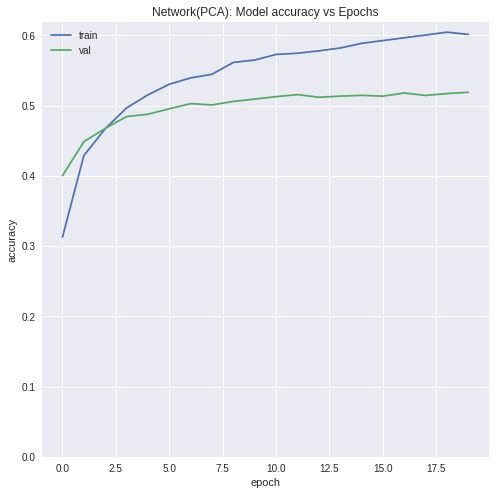

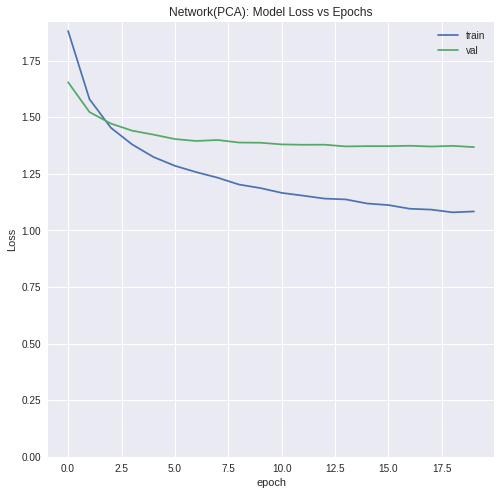

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.837168808778127  mins
[0x012] | Final Test/Val Accuracies of [ 0.28997395833333334 ,  0.27927083333333336 ,],


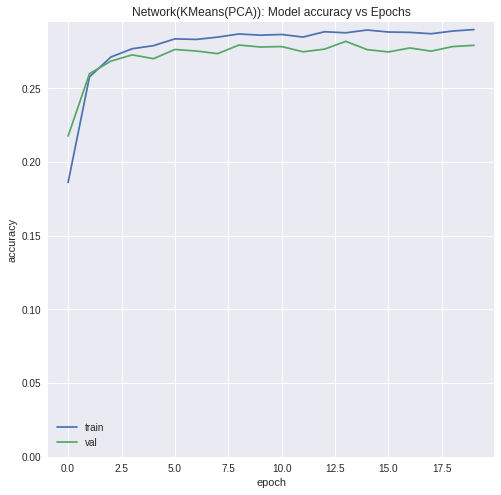

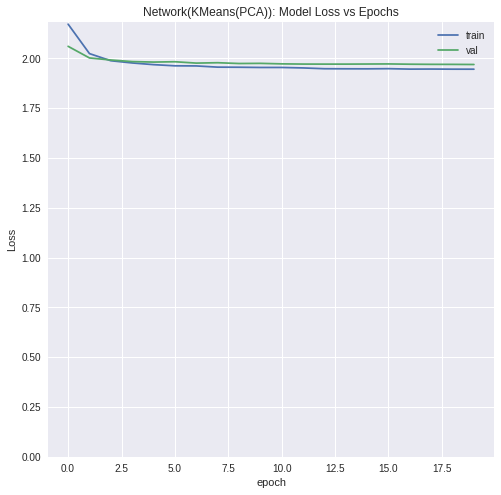

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
   svd_solver='auto', tol=0, whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
   svd_solver='auto', tol=0, whiten=True))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, pre

In [0]:
run_final_experiments(km_mixins, final_pca_pipeline, "PCA", "KMeans",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

#### GMM Experiments

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00688751 0.2375001  0.09308701]
[0x018] | Val Results:  [0.00658345 0.28714594 0.11287427]
[0x019] | Test Results:  [0.00666839 0.27468827 0.10776196]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.01920428 0.15184702 0.08457527]
[0x018] | Val Results:  [0.0190223  0.15913494 0.09325111]
[0x019] | Test Results:  [0.01941752 0.1462914  0.08529899]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

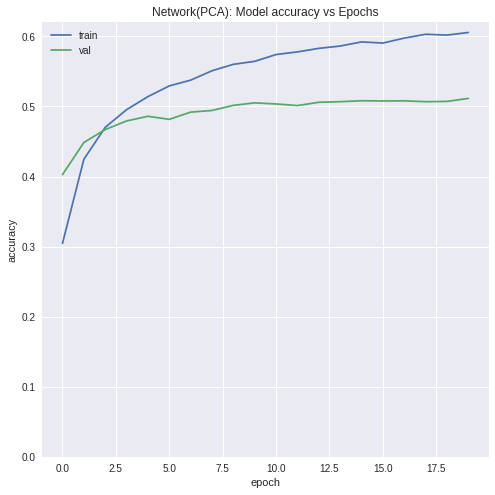

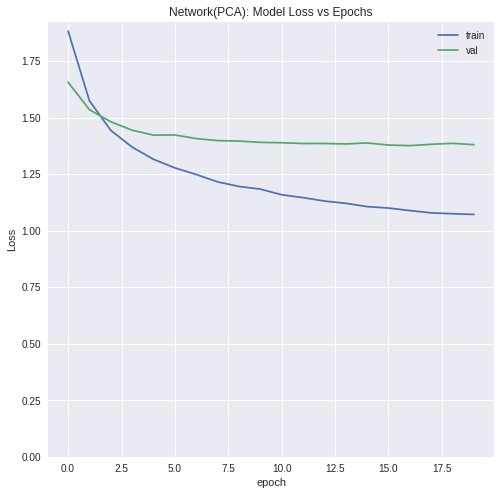

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.7501251459121705  mins
[0x012] | Final Test/Val Accuracies of [ 0.2603125 ,  0.2557291666666667 ,],


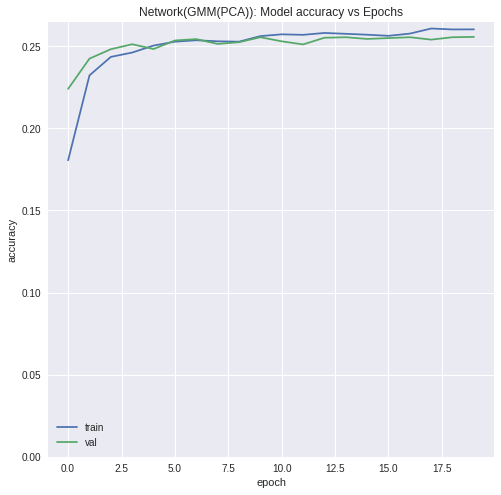

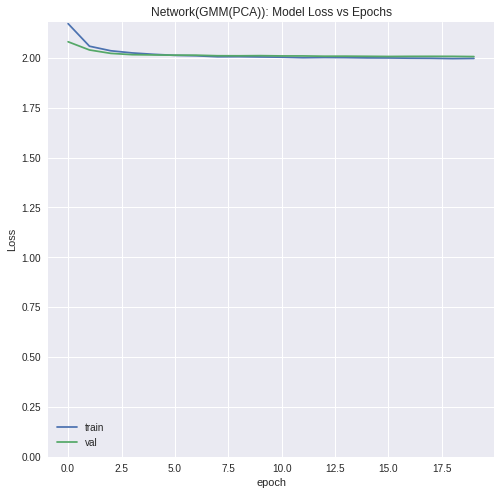

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=10, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
   svd_solver='auto', tol=0, whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
   svd_solver='auto', tol=0, whiten=True))])), ('clust', Pipeline(memory=None,
      steps=[(...        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         w

In [0]:
run_final_experiments(gmm_mixins, final_pca_pipeline, "PCA", "GMM",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

### Visualizations

In [0]:
# Reconstruction takes about a minute...
pca_recons_dataset = val_set[0]
pca_dim = pca_num_components(final_pca)
pca_transformed_data = final_pca_pipeline.transform(pca_recons_dataset)
pca_reconstructions = final_pca_pipeline.inverse_transform(pca_transformed_data)
pca_axes = final_pca.components_

print("[0x027] | " + "Pca-Transformed Data: ", pca_transformed_data.shape)
print("[0x028] | " + "Pca Reductions: ", pca_reconstructions.shape)
print("[0x029] | " + "Pca Axes: ", pca_axes.shape)

In [0]:
#######################################################################
# Warning: Everything from here down will have to be changed for IMDB #
#######################################################################
# Fairly obvious what happens here
print("[0x02a] | " + "The Number of Components found by PCA was: ", pca_dim)

# Plot the distribution of explained variances
pca_top_n = min(5 * 2, pca_dim)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Explained Variance Frac")
ax1.set(ylabel="% of Total Explained Variance")
ax2.set_title("Explained Variance Frac of First " + str(pca_top_n) + " Components")
ax1.plot(np.arange(pca_num_components(final_pca)), pca_explained_variance_ratio(final_pca), 'bo-')
ax2.plot(np.arange(pca_top_n), pca_explained_variance_ratio(final_pca)[:pca_top_n], 'bo-')

# Show the reconstruction results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
plt.title("Image Reconstructions with " + str(pca_num_components(final_pca)) + " components")
columns = 4
rows = 5
for i in range(1, columns*rows +1, 2):
    orig_img = np.reshape(pca_recons_dataset[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(orig_img)
    recon_img = np.reshape(pca_reconstructions[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(recon_img)
plt.show()

# Show the axes results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
columns = 4
rows = 5
plt.title("First " + str(columns * rows) + " PCA Axes")
for i in range(1, min(columns*rows, pca_dim) + 1, 1):
    axis_blank = np.zeros(pca_dim)
    axis_blank[i - 1] = 1
    axis_img = final_pca_pipeline.inverse_transform([axis_blank]).astype(int)
    axis_img = axis_img.reshape(32, 32, 3)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(axis_img)
plt.show()

 ## Independent Components Analysis & Experiments



### Train Various ICA Configs

In [0]:
# Complexity Looks like O(max_iter * n^2)
# Ica with .001 data and no component limit is .78s
# Ica with .01 data and no component limit is 79s
# ICA with .02 data and no component limit is 320s 
# ICA with .02 data and 200 components is 13.03s
# ICA with .5 data and 200 components 224s [and converges]
# ICA with .5 data and 400 components 373s [and converges]
# ICA with 1 data and 200 components 373s [and converges]

ica_configs = [
    # Balances reconstruction power with number of dimensions, I like this
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                  (KEY_DIMRED, FastICA, {"n_components": 300, "max_iter": 200, "whiten": True, "tol": 0.0001,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]

ica_pipelines = [None] * len(ica_configs)

for index, cfg in enumerate(ica_configs):
    print("[0x02b] | " + "ICA Run ", index)
    print("[0x02c] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    ica_pipelines[index] = pipeline
    ica_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x02d] | " + "Finished in ", (end_time - start_time), " seconds")

[0x02b] | ICA Run  0
[0x02c] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class 'sklearn.decomposition.fastica_.FastICA'>, {'n_components': 300, 'max_iter': 200, 'whiten': True, 'tol': 0.0001})], 'training': {'reps': 1}}
[0x02d] | Finished in  317.270179271698  seconds


In [0]:
# Experiments for ICA
if len(ica_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one ICA configuration detected!!!!!!")   
final_ica_pipeline = ica_pipelines[0]
final_ica = final_ica_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00688187 0.22417413 0.08875566]
[0x018] | Val Results:  [0.00687853 0.27768259 0.11058718]
[0x019] | Test Results:  [0.00667012 0.25581891 0.10163468]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.01950288 0.14189532 0.07824286]
[0x018] | Val Results:  [0.02043446 0.14559471 0.08184185]
[0x019] | Test Results:  [0.01999211 0.13964859 0.07856546]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

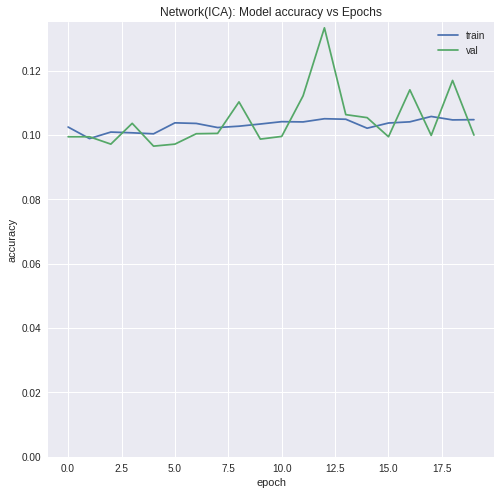

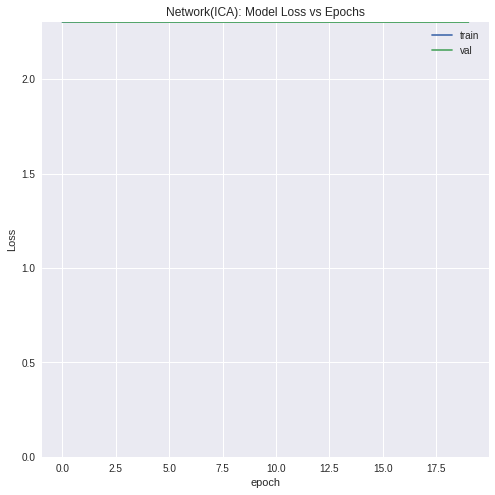

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.7731995622316996  mins
[0x012] | Final Test/Val Accuracies of [ 0.25518229166666667 ,  0.26104166666666667 ,],


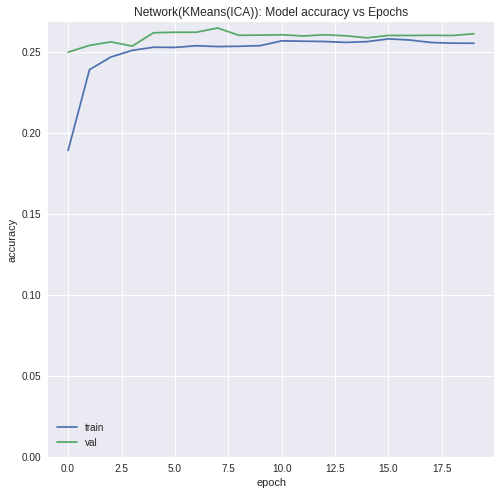

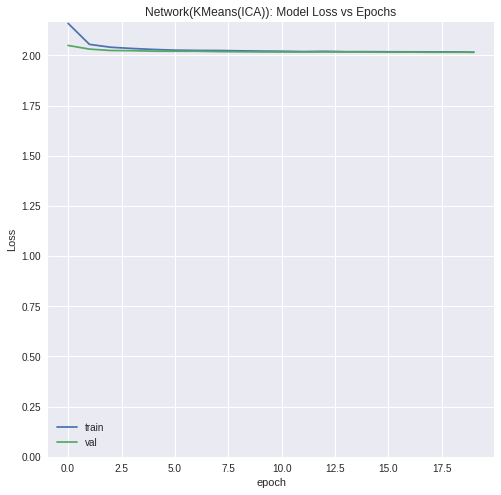

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.0001, w_init=None,
     whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.0001, w_init=None,
     whiten=True))])), ('cl... n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=

In [0]:
run_final_experiments(km_mixins, final_ica_pipeline, "ICA", "KMeans",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

#### GMM Experiments

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00677739 0.2367864  0.09266055]
[0x018] | Val Results:  [0.00675375 0.29360483 0.11523686]
[0x019] | Test Results:  [0.0065431  0.27283962 0.10691681]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.02179365 0.09854244 0.07389334]
[0x018] | Val Results:  [0.01968149 0.09308487 0.07549868]
[0x019] | Test Results:  [0.02168727 0.09506038 0.07608178]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

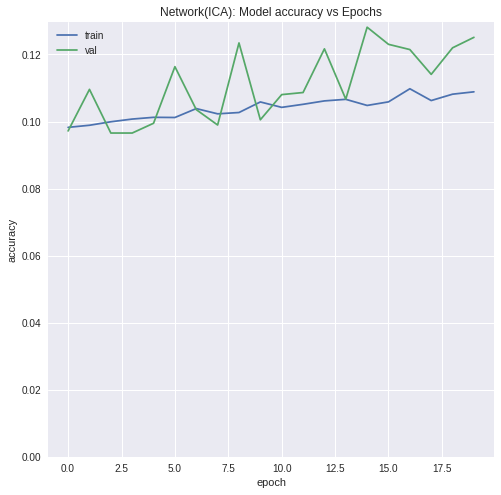

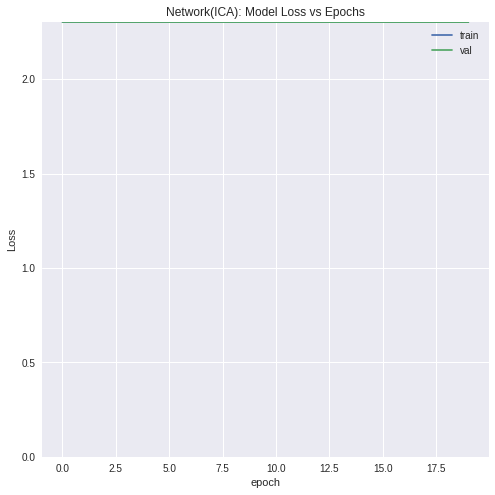

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.7730080405871074  mins
[0x012] | Final Test/Val Accuracies of [ 0.19921875 ,  0.1875 ,],


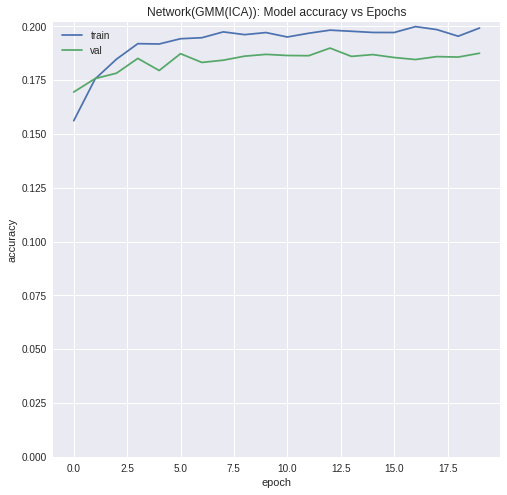

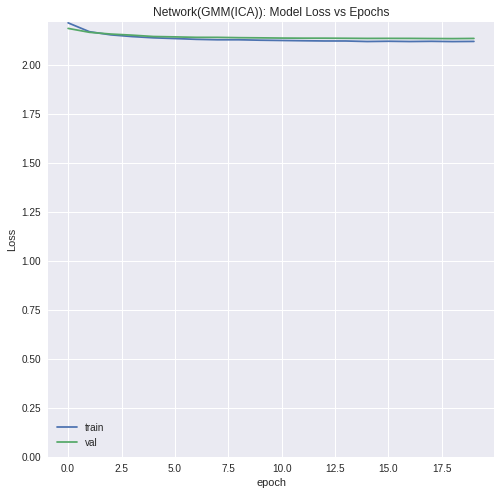

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=10, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.0001, w_init=None,
     whiten=True))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
     n_components=300, random_state=None, tol=0.0001, w_init=None,
     whiten=True))])), ('cl...        tol=0.001, verbose=0, verbose

In [0]:
run_final_experiments(gmm_mixins, final_ica_pipeline, "ICA", "GMM",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

### Visualizations

In [0]:
# Reconstruction takes about a minute...
ica_recons_dataset = val_set[0]
ica_dim = pca_num_components(final_ica)
ica_transformed_data = final_ica_pipeline.transform(ica_recons_dataset)
ica_reconstructions = final_ica_pipeline.inverse_transform(ica_transformed_data)
ica_axes = final_ica.components_

print("[0x02e] | " + "ICA-Transformed Data: ", ica_transformed_data.shape)
print("[0x02f] | " + "ICA Reductions: ", ica_reconstructions.shape)
print("[0x030] | " + "ICA Axes: ", ica_axes.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Number of Components found by ICA was:  300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


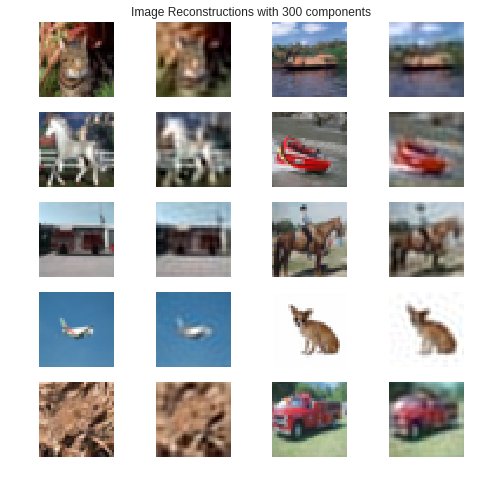

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

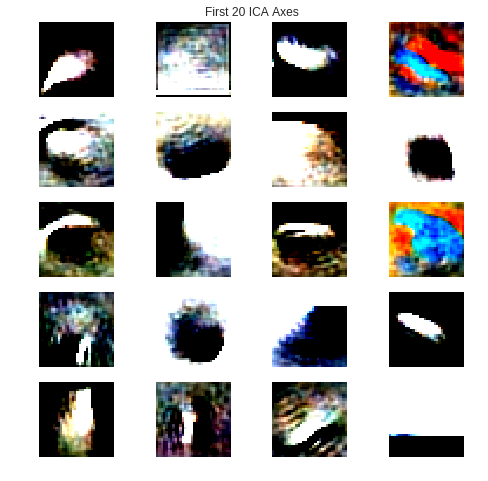

In [0]:
#######################################################################
# Warning: Everything from here down will have to be changed for IMDB #
#######################################################################
# Fairly obvious what happens here
print("[0x031] | " + "The Number of Components found by ICA was: ", ica_dim)

# Show the reconstruction results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
plt.title("Image Reconstructions with " + str(pca_num_components(final_ica)) + " components")
columns = 4
rows = 5
for i in range(1, columns*rows +1, 2):
    orig_img = np.reshape(ica_recons_dataset[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(orig_img)
    recon_img = np.reshape(ica_reconstructions[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(recon_img)
plt.show()

# Show the axes results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
columns = 4
rows = 5
plt.title("First " + str(columns * rows) + " ICA Axes")
for i in range(1, min(columns*rows, ica_dim) + 1, 1):
    axis_blank = np.zeros(ica_dim)
    axis_blank[i - 1] = 1
    axis_img = final_ica_pipeline.inverse_transform([axis_blank]).astype(int)
    axis_img = axis_img.reshape(32, 32, 3)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(axis_img)
plt.show()

 ## Randomized Projections

### Training the RCA configs

In [0]:
rp_configs = [
    # Bad performance lmoa, but takes five seconds with 100% data!
    # As good as we're going to get, given that we're not reducing dimensionality at all
    {KEY_PIPELINE: [(KEY_PREPROC, StandardScaler, {"with_mean": True, "with_std": True}),
                  (KEY_DIMRED, GRP, {"n_components": 3072, "eps": 0.1,}),],
     KEY_TRAINING: {KEY_REPS: 1},},
]

rp_pipelines = [None] * len(rp_configs)

for index, cfg in enumerate(rp_configs):
    print("[0x032] | " + "RP Run ", index)
    print("[0x033] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    rp_pipelines[index] = pipeline
    rp_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x034] | " + "Finished in ", (end_time - start_time), " seconds")


[0x032] | RP Run  0
[0x033] | Configuration:  {'pipeline': [('preproc', <class 'sklearn.preprocessing.data.StandardScaler'>, {'with_mean': True, 'with_std': True}), ('dimred', <class 'sklearn.random_projection.GaussianRandomProjection'>, {'n_components': 3072, 'eps': 0.1})], 'training': {'reps': 1}}
[0x034] | Finished in  3.924311637878418  seconds


In [0]:
# Experiments for RP
if len(rp_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one RP configuration detected!!!!!!")   
final_rp_pipeline = rp_pipelines[0]
final_rp = final_rp_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.0066789  0.22503462 0.08904664]
[0x018] | Val Results:  [0.00659891 0.27822045 0.11060467]
[0x019] | Test Results:  [0.00660381 0.26043131 0.10326527]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.0067511  0.22150273 0.08786332]
[0x018] | Val Results:  [0.00682137 0.2775897  0.11059681]
[0x019] | Test Results:  [0.00647581 0.25353778 0.10082051]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

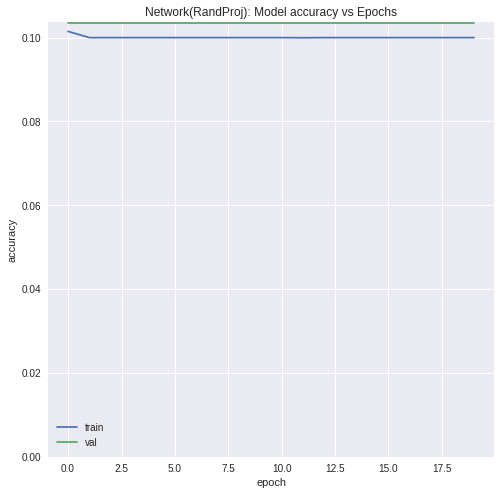

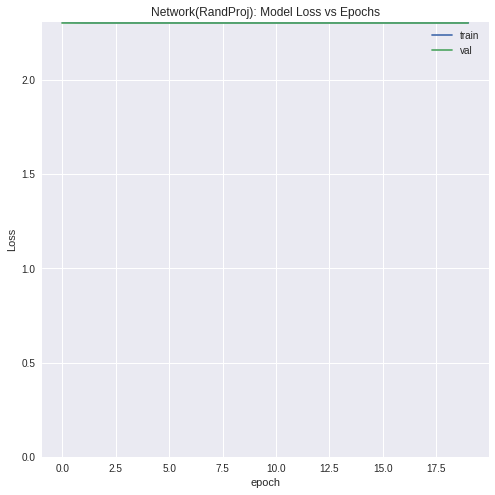

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.7949296871821085  mins
[0x012] | Final Test/Val Accuracies of [ 0.33526041666666667 ,  0.3290625 ,],


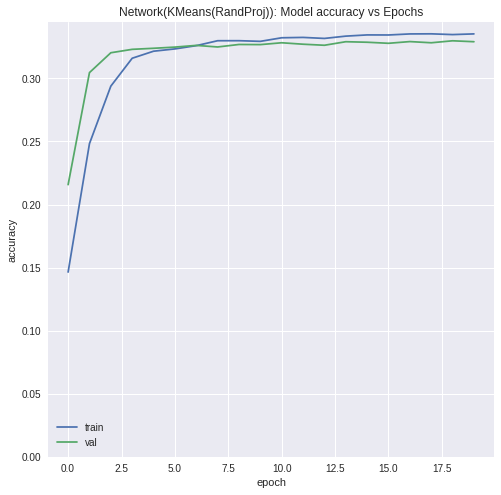

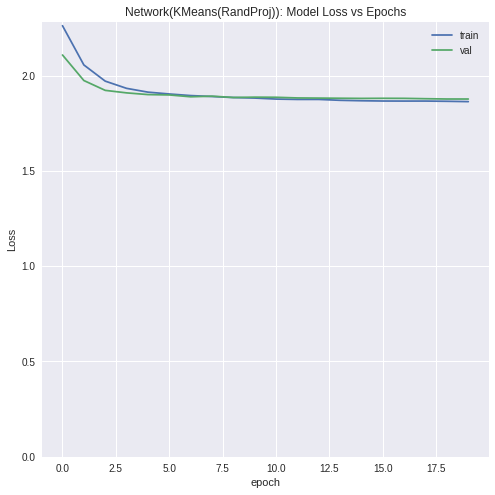

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', GaussianRandomProjection(eps=0.1, n_components=3072, random_state=None))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', GaussianRandomProjection(eps=0.1, n_components=3072, random_state=None))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]))]), <__main__.

In [0]:
run_final_experiments(km_mixins, final_rp_pipeline, "RandProj", "KMeans",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

#### GMM Experiments

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00695072 0.23567444 0.09256459]
[0x018] | Val Results:  [0.00659403 0.28589164 0.1124759 ]
[0x019] | Test Results:  [0.00681504 0.27531826 0.10818487]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00696492 0.23629612 0.09263082]
[0x018] | Val Results:  [0.00663174 0.28225569 0.11106772]
[0x019] | Test Results:  [0.00645478 0.26993343 0.10584514]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

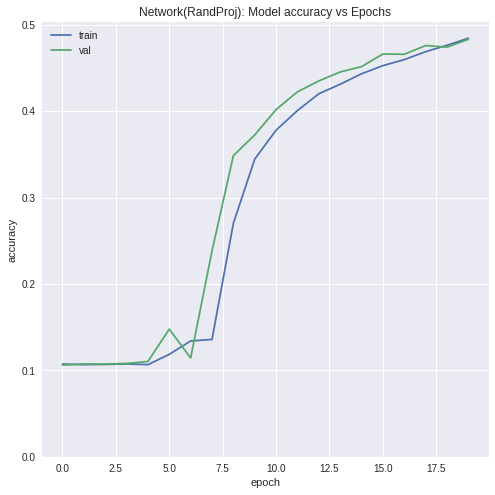

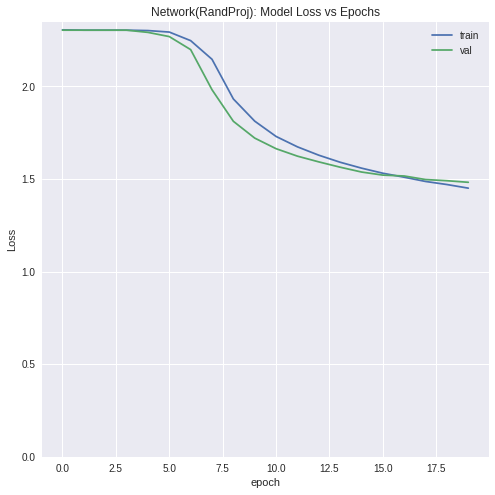

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.8240392486254373  mins
[0x012] | Final Test/Val Accuracies of [ 0.346640625 ,  0.34197916666666667 ,],


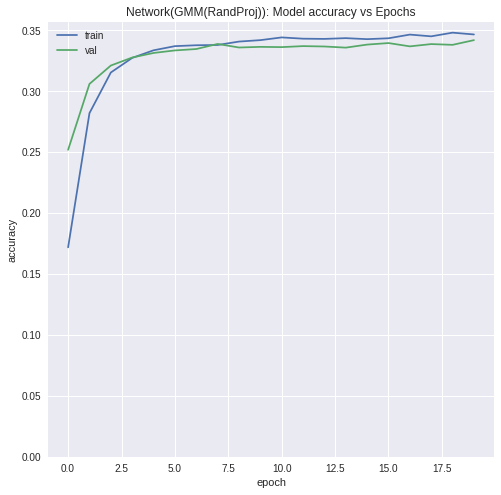

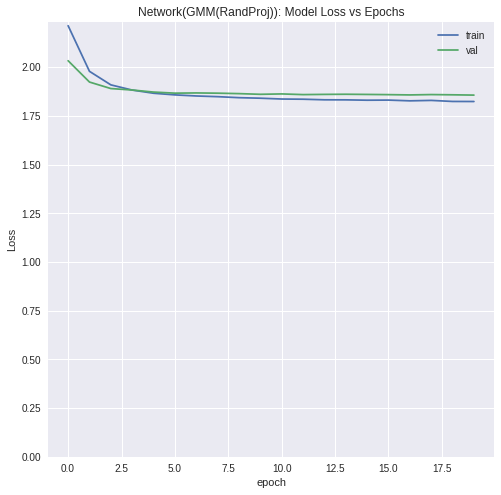

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=10, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]), Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', GaussianRandomProjection(eps=0.1, n_components=3072, random_state=None))]), Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dimred', GaussianRandomProjection(eps=0.1, n_components=3072, random_state=None))])), ('clust', Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='sp...        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]))]), <__main__.OneHotted_C

In [0]:
run_final_experiments(gmm_mixins, final_rp_pipeline, "RandProj", "GMM",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

### Visualizations

In [0]:
def invert_rp(projection, projected_data):
    proj_axes = projection.components_
    try:
        proj_axes = proj_axes.toarray()
    except AttributeError:
        pass      
    return np.matmul(projected_data, proj_axes)
  
# TODO Why does GRP not support inverse_transform?! This is a crime!!
def invert_rp_pipeline(pipeline, projected_data):
    tform = lambda x: x
    if pipeline.named_steps[KEY_PREPROC] is not None:
        tform = lambda x: pipeline.named_steps[KEY_PREPROC].inverse_transform(x)
    return tform(invert_rp(pipeline.named_steps[KEY_DIMRED], projected_data))

# Reconstruction takes about a minute...
rp_recons_dataset = val_set[0]
rp_dim = pca_num_components(final_rp)
rp_transformed_data = final_rp_pipeline.transform(rp_recons_dataset)
rp_reconstructions = invert_rp_pipeline(final_rp_pipeline, rp_transformed_data)
rp_axes = final_rp.components_

print("[0x035] | " + "RP-Transformed Data: ", rp_transformed_data.shape)
print("[0x036] | " + "RP Reconstruction: ", rp_reconstructions.shape)
print("[0x037] | " + "RP Axes: ", rp_axes.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The Number of Components found by RP was:  3072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


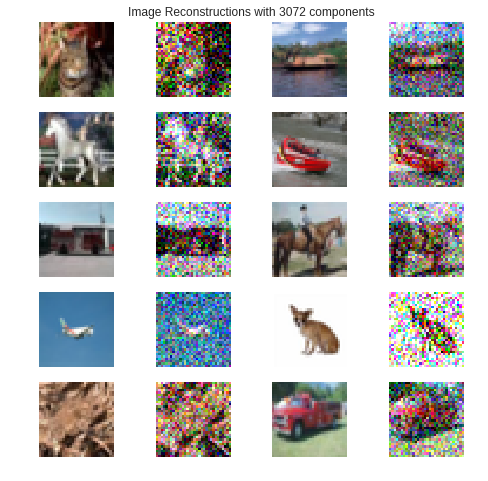

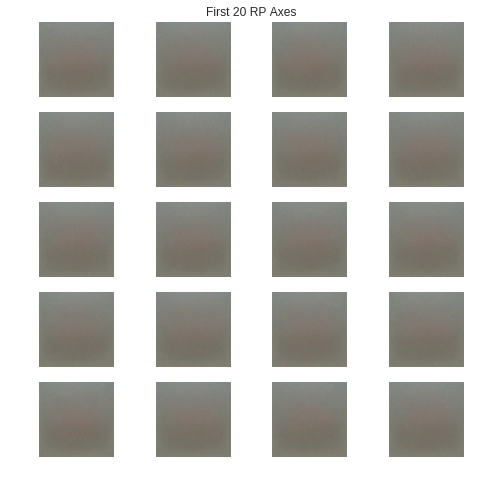

In [0]:
#######################################################################
# Warning: Everything from here down will have to be changed for IMDB #
#######################################################################
# Fairly obvious what happens here
print("[0x038] | " + "The Number of Components found by RP was: ", rp_dim)

# Show the reconstruction results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
plt.title("Image Reconstructions with " + str(pca_num_components(final_rp)) + " components")
columns = 4
rows = 5
for i in range(1, columns*rows +1, 2):
    orig_img = np.reshape(rp_recons_dataset[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(orig_img)
    recon_img = np.reshape(rp_reconstructions[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(recon_img)
plt.show()

# Show the axes results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
columns = 4
rows = 5
plt.title("First " + str(columns * rows) + " RP Axes")
for i in range(1, min(columns*rows, rp_dim) + 1, 1):
    axis_blank = np.zeros(rp_dim)
    axis_blank[i - 1] = 1
    axis_img = invert_rp_pipeline(final_rp_pipeline, axis_blank).astype(int)
    axis_img = axis_img.reshape(32, 32, 3)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(axis_img)
plt.show()

## Variance-Threshold feature selection

### Training the FeatureSelector Configs

In [0]:
fs_configs = [
    # Looks kinda dumb, but not *totally* dumb
    {KEY_PIPELINE: [(KEY_DIMRED, VTSelector, {"threshold": 3700,})], KEY_TRAINING: {KEY_REPS: 1},},
]

fs_pipelines = [None] * len(fs_configs)

for index, cfg in enumerate(fs_configs):
    print("[0x039] | " + "FS Run ", index)
    print("[0x03a] | " + "Configuration: ", cfg)
    
    pipeline = get_pipeline(cfg[KEY_PIPELINE])
    start_time = time.time()
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
       
    fs_pipelines[index] = pipeline
    fs_pipelines[index].fit(train_set[0])
    
    warnings.resetwarnings()
    end_time = time.time()
    print("[0x03b] | " + "Finished in ", (end_time - start_time), " seconds")

[0x039] | FS Run  0
[0x03a] | Configuration:  {'pipeline': [('dimred', <class 'sklearn.feature_selection.variance_threshold.VarianceThreshold'>, {'threshold': 3700})], 'training': {'reps': 1}}
[0x03b] | Finished in  1.2144384384155273  seconds


In [0]:
# Experiments for FS
if len(fs_pipelines) != 1:
    raise RuntimeWarning("Warning: More than one FS configuration detected!!!!!!")   
final_fs_pipeline = fs_pipelines[0]
final_fs = final_fs_pipeline.named_steps[KEY_DIMRED]

### Experiments

#### KMeans Experiments

[0x010] | WARNING: Discarding all but the last entry of clusterspec
[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00681167 0.22204481 0.08796324]
[0x018] | Val Results:  [0.0065675  0.27473165 0.10916247]
[0x019] | Test Results:  [0.00654358 0.25534393 0.10140308]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00619809 0.20431345 0.08080086]
[0x018] | Val Results:  [0.00610736 0.25600955 0.10177498]
[0x019] | Test Results:  [0.00618349 0.24000572 0.09524769]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] 

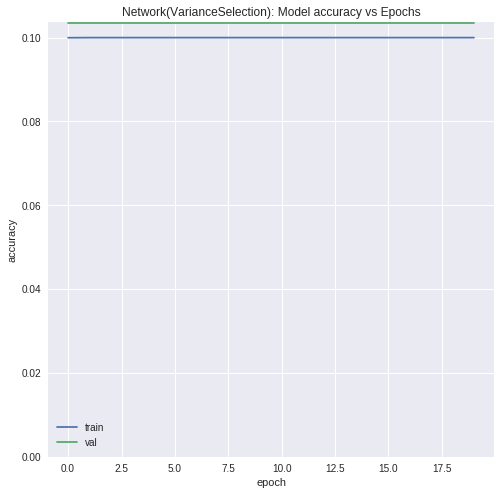

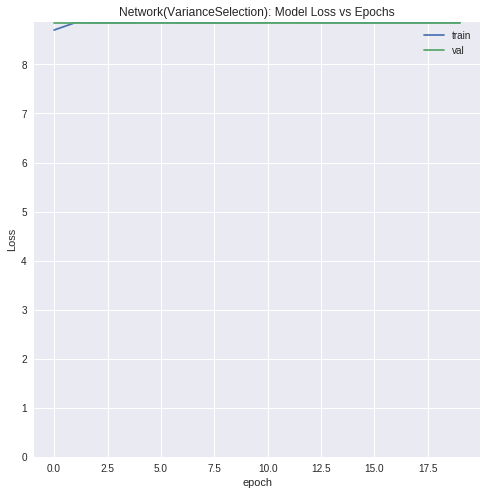

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.83719406525294  mins
[0x012] | Final Test/Val Accuracies of [ 0.3166145833333333 ,  0.3078125 ,],


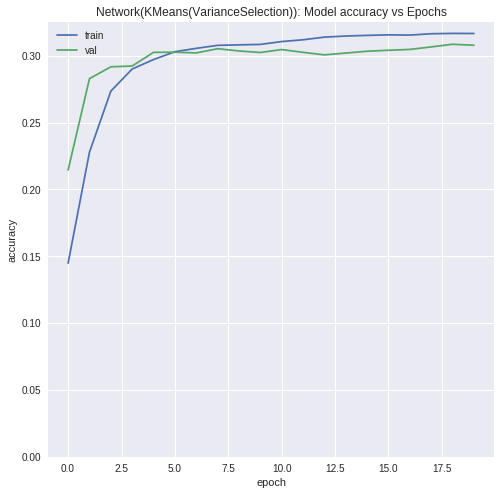

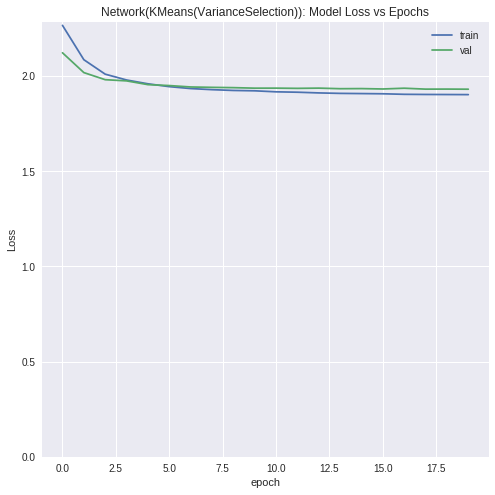

(Pipeline(memory=None,
      steps=[('preproc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]),
 Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=3700))]),
 Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=3700))])), ('clust', Pipeline(memory=None,
      steps=[('clust', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=400, n_init=1, n_jobs=5, precompute_distances='auto',
     random_state=None, tol=0.0001, verbose=0))]))]),
 <__main__.OneHotted_ClusterPipeline at 0x7f77d51ccba8>)

In [0]:
run_final_experiments(km_mixins, final_fs_pipeline, "VarianceSelection", "KMeans",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

#### GMM Experiments

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


[0x041] | ===============================================================
[0x042] | ===============================================================
[0x043] | Experiment: Clustering of raw data
[0x044] | 
[0x017] | Train Results:  [0.00689542 0.23975357 0.09374831]
[0x018] | Val Results:  [0.00662452 0.29101108 0.11404366]
[0x019] | Test Results:  [0.00660727 0.27964266 0.10935355]
[0x013] | ===============================================================
[0x014] | ===============================================================
[0x015] | Experiment: Clustering of dim-reduced data
[0x016] | 
[0x017] | Train Results:  [0.00602443 0.21555511 0.08428409]
[0x018] | Val Results:  [0.00584843 0.26919135 0.10540941]
[0x019] | Test Results:  [0.00589697 0.25649878 0.10031796]
[0x046] | ===============================================================
[0x047] | ===============================================================
[0x049] | Experiment: Comparison of CL and DRCL Pipelines
[0x049] | 
[0x04a]

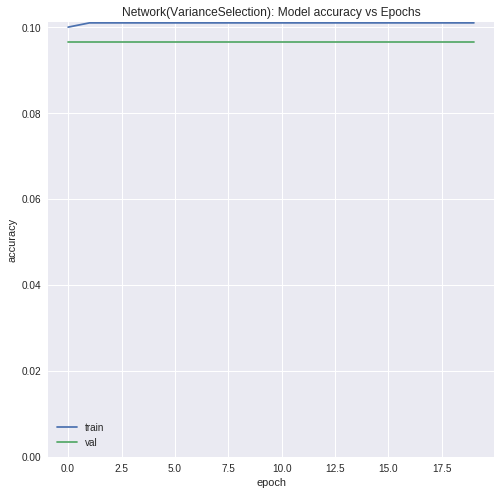

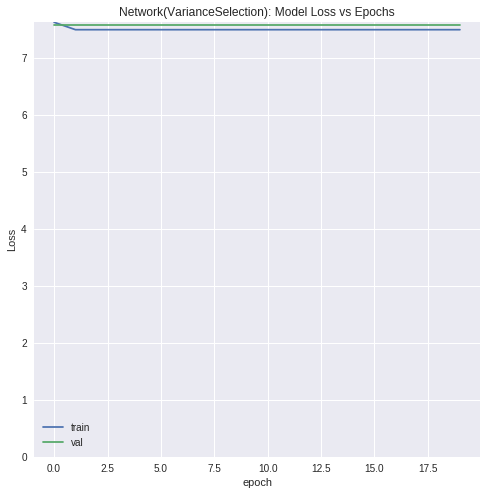

[0x01e] | ===============================================================
[0x01f] | ===============================================================
[0x020] | Experiment: Neural Network of clusters of dim-reduced data
[0x021] | 
[0x011] | Finished fitting in  1.8621574878692626  mins
[0x012] | Final Test/Val Accuracies of [ 0.3241145833333333 ,  0.31145833333333334 ,],


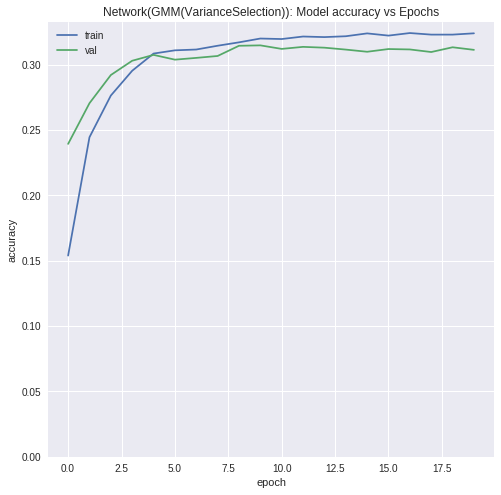

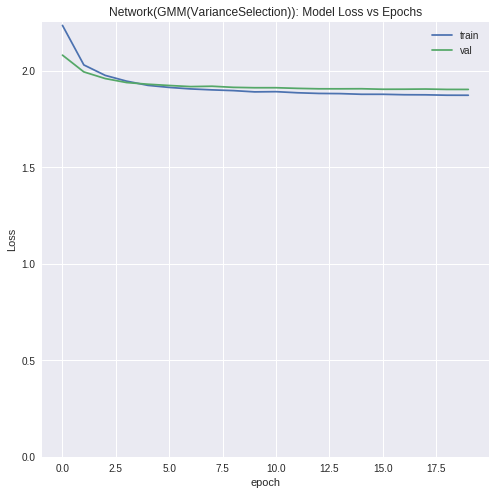

(Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=10, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]),
 Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=3700))]),
 Pipeline(memory=None,
      steps=[('dimred', Pipeline(memory=None, steps=[('dimred', VarianceThreshold(threshold=3700))])), ('clust', Pipeline(memory=None,
      steps=[('clust', GaussianMixture(covariance_type='spherical', init_params='kmeans',
         max_iter=10, means_init=None, n_components=400, n_init=1,
         precisions_init=None, random_state=None, reg_covar=1e-06,
         tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
         weights_init=None))]))]),
 <__main__.OneHotted_ClusterPipeline at 0x7f77d4c75eb8>)

In [0]:
run_final_experiments(gmm_mixins, final_fs_pipeline, "VarianceSelection", "GMM",
                      split_datasets, experiment_flags=(True, True, True, True),
                      verbose=0)

### Visualizations

In [0]:
# Reconstruction takes about a minute...
fs_recons_dataset = val_set[0]
fs_transformed_data = final_fs_pipeline.transform(fs_recons_dataset)
fs_dim = fs_transformed_data.shape[1]
fs_reconstructions = final_fs_pipeline.inverse_transform(fs_transformed_data)

__mapped_all = final_fs_pipeline.transform(np.ones(DATA_DIMENSIONALITY).reshape(1, -1))
chosen_components = final_fs_pipeline.inverse_transform(__mapped_all)

print("[0x03c] | " + "FS-Transformed Data: ", fs_transformed_data.shape)
print("[0x03d] | " + "FS Reconstructions: ", fs_reconstructions.shape)

The Number of Components found by FS was:  1793


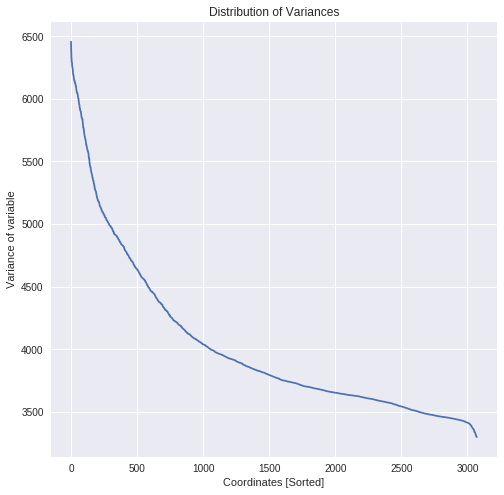

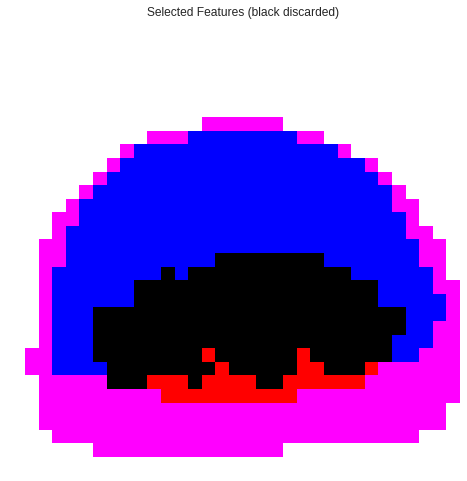

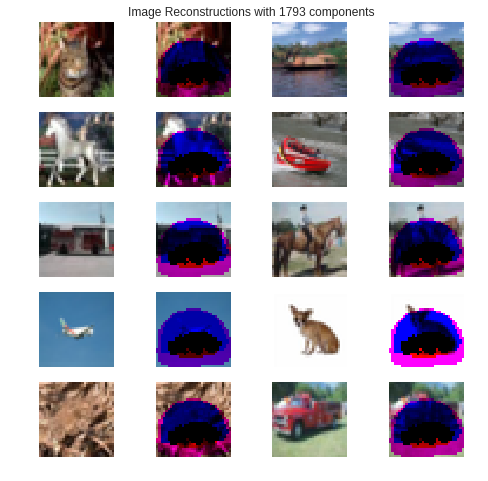

In [0]:
#######################################################################
# Warning: Everything from here down will have to be changed for IMDB #
#######################################################################
# Fairly obvious what happens here
print("[0x03e] | " + "The Number of Components found by FS was: ", fs_dim)

# Visualize the distribution of variances...
fig = plt.figure(figsize=(8, 8))
plt.title("Distribution of Variances")
variances = np.array(sorted(final_fs.variances_.copy())[::-1])
plt.xlabel("Coordinates [Sorted]")
plt.ylabel("Variance of variable")
plt.plot(np.arange(DATA_DIMENSIONALITY), variances)

# Visualize which features were selected
fig=plt.figure(figsize=(8, 8))
plt.title("Selected Features (black discarded)")
plt.axis('off')
plt.grid(False)
plt.imshow(chosen_components.reshape(32, 32, 3).astype(float))
plt.show()

# Show the reconstruction results
w = h = 32
fig=plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(False)
plt.title("Image Reconstructions with " + str(fs_dim) + " components")
columns = 4
rows = 5
for i in range(1, columns*rows +1, 2):
    orig_img = np.reshape(fs_recons_dataset[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(orig_img)
    recon_img = np.reshape(fs_reconstructions[i].astype(int), newshape=(32, 32, 3))
    fig.add_subplot(rows, columns, i + 1)
    plt.axis('off')
    plt.grid(False)
    plt.imshow(recon_img)
plt.show()